In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.style.use('ggplot')
%matplotlib inline

titanic = pd.read_csv("data/train.csv")
titanic_nan = titanic.dropna(subset=['Age', 'Sex', 'Pclass'])

N = len(titanic)
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


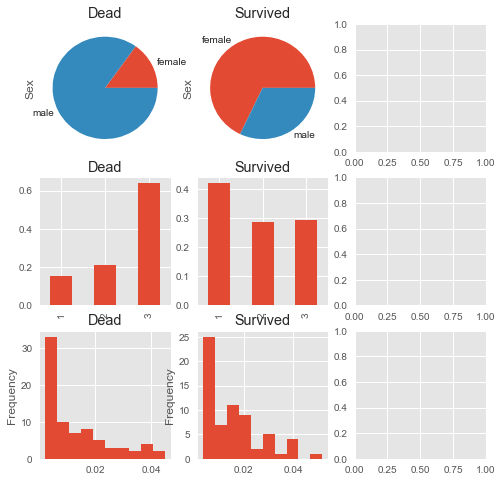

In [98]:
class DataInfo():
    def __init__(self, column, vis, continuous, category, sort=False):
        self.column = column
        self.vis = vis
        self.continuous = continuous
        self.category = category
        self.sort=sort

base_key = 'Survived'
infos = [
    DataInfo('Sex', 'pie', False, True),
    DataInfo('Pclass', 'bar', False, False),
    DataInfo('Age', 'hist', True, False,sort=True),
]
fig, axes = plt.subplots(len(infos), 3, figsize=(8, 8))

for i, info in enumerate(infos):
    for v, title in [(0, "Dead"), (1, "Survived")]:
        t = titanic_nan[titanic_nan[base_key] == v][info.column]
        ax = axes[i][v]
        t.value_counts(base_key, sort=info.sort).plot(kind=info.vis,ax=ax, title=title)
        

In [129]:
# 子ども？
def is_child(age):
    if pd.isnull(age):
        return False
    if age < 12:
        return True
    return False

In [130]:
# 子どもカラムの追加
titanic_c = titanic.assign(
    Child=titanic['Age'].map(is_child)
)

#※ Assignは破壊的ではない
titanic.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [138]:
import patsy
from sklearn import tree
from sklearn.feature_extraction import DictVectorizer

exp_values = [
    'C(Pclass)',
    'C(Sex)',
    'C(Child)'
]

predict_value = 'Survived'
c_df = patsy.dmatrix('+ '.join(exp_values) + ' + ' + predict_value, data=titanic_c, return_type='dataframe')
c_df.groupby(predict_value).count()

,Intercept,C(Pclass)[T.2],C(Pclass)[T.3],C(Sex)[T.male],C(Child)[T.True]
Survived,,,,,
0.0,549,549,549,549,549
1.0,342,342,342,342,342


In [139]:
#使いそうな値をを宣言しておく
columns = list(c_df.columns)
columns.remove('Intercept')
columns.remove(predict_value)

harf = int(N // 2)
columns

c_df[:harf].groupby(predict_value).count()

,Intercept,C(Pclass)[T.2],C(Pclass)[T.3],C(Sex)[T.male],C(Child)[T.True]
Survived,,,,,
0.0,271,271,271,271,271
1.0,174,174,174,174,174


## 決定木

In [169]:

import patsy
from sklearn import tree
from sklearn.feature_extraction import DictVectorizer

decision_tree_model = tree.DecisionTreeClassifier(max_depth=3)
X = c_df[columns]
Y = c_df[predict_value]

#半分のデータを訓練データとして使う
decision_tree_model.fit(X[:harf], Y[:harf])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

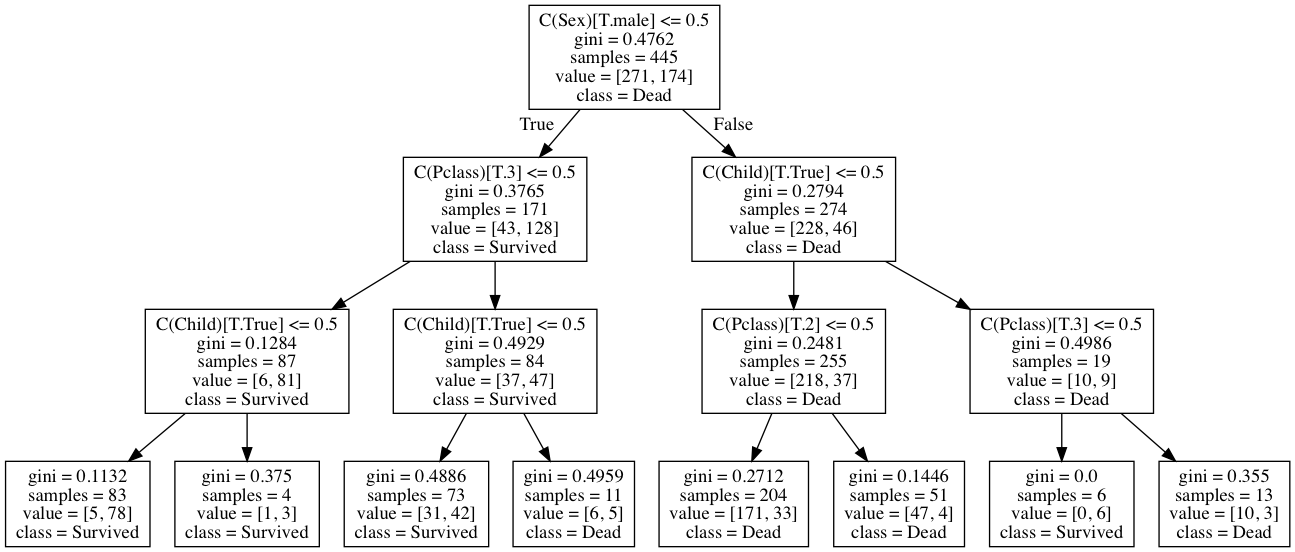

In [170]:
# 描画
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus

dot_data = StringIO()
tree.export_graphviz(
    decision_tree_model,
    out_file=dot_data,
    feature_names=list(X.keys()),
    class_names=['Dead', 'Survived']
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

In [187]:
## 正答率チェッカー
def predict(model, X, Y):
    model.fit(X[:harf], Y[:harf])
    test = model.predict(X[:harf])
    correct = sum([int(p==r) for p, r in zip(test, list(Y))])
    print('訓練データの成功率:', correct / harf)

    # 正答率は？
    test = model.predict(X[harf:])
    correct = sum([int(p==r) for p, r in zip(test, list(Y))])
    print('正答率:', correct / harf)

predict(decision_tree_model, X,Y)

訓練データの成功率: 0.8157303370786517
正答率: 0.5438202247191011


(ﾟдﾟ)！
話にならない・・・。

## ランダムフォレスト, SVM

In [190]:
print("ランダムフォレスト")
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(n_estimators=10, random_state=0)
predict(random_forest_model, X, Y)
print()

print("SVC")
from sklearn.svm import SVC
svc_model = SVC()
predict(svc_model, X, Y)

ランダムフォレスト
訓練データの成功率: 0.8179775280898877
正答率: 0.5438202247191011

SVC
訓練データの成功率: 0.8112359550561797
正答率: 0.5393258426966292


## どれも正答率が低すぎる

原因は？

+ 使ってるデータがよくない
+ サンプルと訓練データの分け方が良くない